In [1]:
from crypto_volatility_lab.data_construction import CryptoScraper, TimeSeriesCreator
import matplotlib.pyplot as plt
import numpy as np

# Web Scraping

### Récupération d'une seule currency

In [2]:
crypto_scraper = CryptoScraper()
bitcoin_data = crypto_scraper.get_data_for_currency('BTC-USD')

In [3]:
print(bitcoin_data.shape)
bitcoin_data.head()

(3768, 7)


,Date,Open,High,Low,Close,Adj,Volume
0,"Jan 9, 2025","95,038.08","95,306.11","92,827.66","93,462.05","93,462.05","63,813,513,216"
1,"Jan 8, 2025","96,924.16","97,258.32","92,525.84","95,043.52","95,043.52","63,875,859,171"
2,"Jan 7, 2025","102,248.85","102,712.48","96,132.88","96,922.70","96,922.70","58,685,738,547"
3,"Jan 6, 2025","98,314.95","102,482.88","97,926.15","102,078.09","102,078.09","51,823,432,705"
4,"Jan 5, 2025","98,233.91","98,813.30","97,291.77","98,314.96","98,314.96","20,525,254,825"


#### Création des time series

In [4]:
ts_creator = TimeSeriesCreator(data=bitcoin_data, date_column_name='Date', value_column_name='Close')
log_returns = ts_creator.create_log_return_time_series()
volatility = ts_creator.create_volatility_time_series()

bitcoin_data["Log Returns"] = log_returns
bitcoin_data["Volatility"] = volatility
bitcoin_data.head(5)

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility
3767,2014-09-17,465.86,468.17,452.42,457.33,457.33,"21,056,800",NaN,NaN
3766,2014-09-18,456.86,456.86,413.10,424.44,424.44,"34,483,200",-0.074635,NaN
3765,2014-09-19,424.10,427.83,384.53,394.80,394.80,"37,919,700",-0.072391,NaN
3764,2014-09-20,394.67,423.30,389.88,408.90,408.90,"36,863,600",0.035091,NaN
3763,2014-09-21,408.08,412.43,393.18,398.82,398.82,"26,580,100",-0.024960,NaN


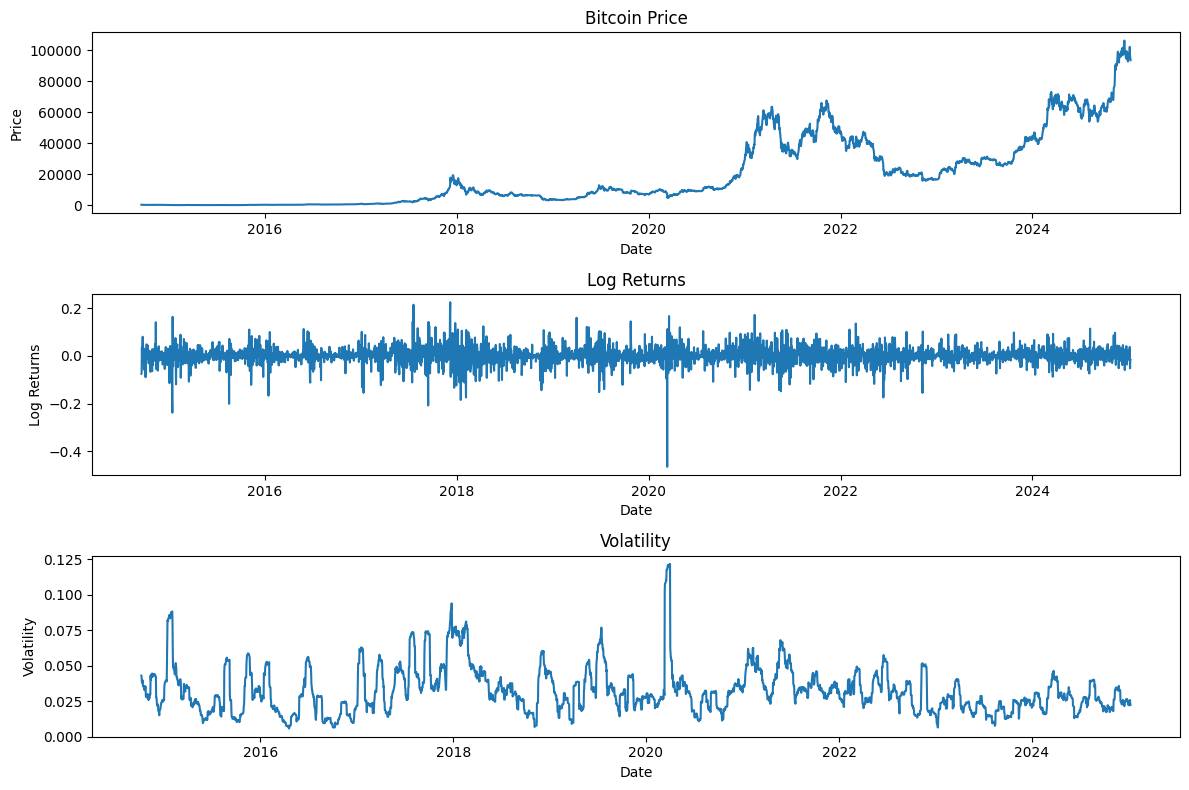

In [5]:
# sort the data by descending date
bitcoin_data = bitcoin_data.sort_values(by="Date", ascending=True)

# plotting time series by date
fig, ax = plt.subplots(3, 1, figsize=(12, 8))

ax[0].plot(bitcoin_data["Date"], bitcoin_data["Close"])
ax[0].set_title("Bitcoin Price")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Price")

ax[1].plot(bitcoin_data["Date"], bitcoin_data["Log Returns"])
ax[1].set_title("Log Returns")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Log Returns")

ax[2].plot(bitcoin_data["Date"], bitcoin_data["Volatility"])
ax[2].set_title("Volatility")
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Volatility")



plt.tight_layout()
plt.show()

### Modèle GARCH

In [6]:
from crypto_volatility_lab.data_construction import FeaturesCreator
features_creator = FeaturesCreator()

In [7]:
len(bitcoin_data)

3768

In [8]:
bitcoin_data.dropna(inplace=True)

In [9]:
len(bitcoin_data)

3747

In [13]:
bitcoin_data

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility
3746,2014-10-08,336.12,354.36,327.19,352.94,352.94,"54,736,300",0.048622,0.042931
3745,2014-10-09,352.75,382.73,347.69,365.03,365.03,"83,641,104",0.033681,0.041557
3744,2014-10-10,364.69,375.07,352.96,361.56,361.56,"43,665,700",-0.009552,0.038797
3743,2014-10-11,361.36,367.19,355.95,362.30,362.30,"13,345,200",0.002045,0.037781
3742,2014-10-12,362.61,379.43,356.14,378.55,378.55,"17,552,800",0.043876,0.038999
...,...,...,...,...,...,...,...,...,...
4,2025-01-05,"98,233.91","98,813.30","97,291.77",98314.96,"98,314.96","20,525,254,825",0.000801,0.021971
3,2025-01-06,"98,314.95","102,482.88","97,926.15",102078.09,"102,078.09","51,823,432,705",0.037562,0.023337
2,2025-01-07,"102,248.85","102,712.48","96,132.88",96922.70,"96,922.70","58,685,738,547",-0.051824,0.025742
1,2025-01-08,"96,924.16","97,258.32","92,525.84",95043.52,"95,043.52","63,875,859,171",-0.019579,0.022805


In [ ]:
garch_prediction_1 = features_creator.compute_garch_forecast(bitcoin_data["Log Returns"].dropna())
print(len(garch_prediction_1))

3747


In [15]:
garch_prediction_1

3746    0.030919
3745    0.032965
3744    0.032928
3743    0.031521
3742    0.030014
          ...   
4       0.022552
3       0.021775
2       0.023904
1       0.028586
0       0.028132
Name: cond_vol, Length: 3747, dtype: float64

MSE: 4.36629984537833e-05


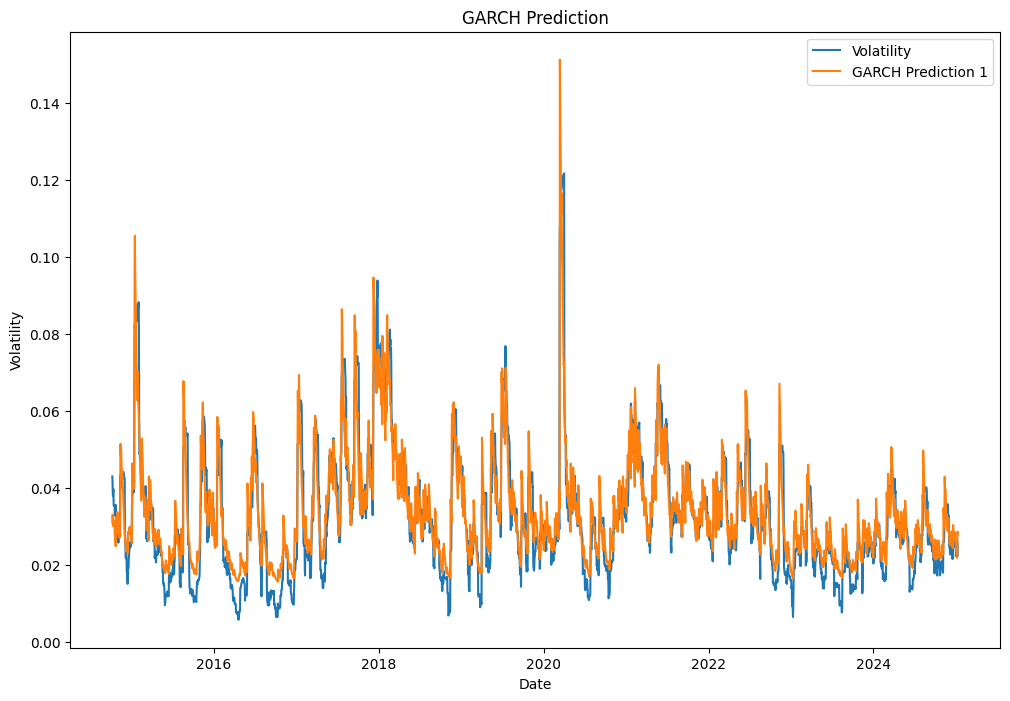

In [12]:
# Compute MSE
mse = np.mean(np.square(bitcoin_data["Volatility"] - garch_prediction_1))
print(f"MSE: {mse}")

# plot the GARCH forecast
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(bitcoin_data["Date"], bitcoin_data["Volatility"], label="Volatility")
ax.plot(bitcoin_data["Date"], garch_prediction_1, label="GARCH Prediction 1")
ax.set_title("GARCH Prediction")
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.legend()

### Récupération des données d'entrainement

In [12]:
features = ts_creator.create_time_series_for_NN_training()
print(features.shape)
features.head(25)

(3737, 6)


,Log Returns,Volatility,GARCH Volatility,Volatility Weekly,Volatility Monthly,Date
3736,-0.031418,0.035361,0.033724,0.037340,0.012887,2014-10-16
3735,0.003132,0.035237,0.033729,0.036831,0.014061,2014-10-17
3734,0.019815,0.035488,0.032060,0.036504,0.015244,2014-10-18
3733,-0.004840,0.033069,0.031041,0.035657,0.016347,2014-10-19
3732,-0.017349,0.033304,0.029645,0.034755,0.017457,2014-10-20
3731,0.009437,0.032699,0.028923,0.034341,0.018547,2014-10-21
3730,-0.008627,0.032699,0.027722,0.033980,0.019637,2014-10-22
3729,-0.066747,0.035521,0.026715,0.034003,0.020821,2014-10-23
3728,-0.000195,0.034305,0.033531,0.033869,0.021964,2014-10-24
3727,-0.031408,0.028677,0.031880,0.032896,0.022920,2014-10-25


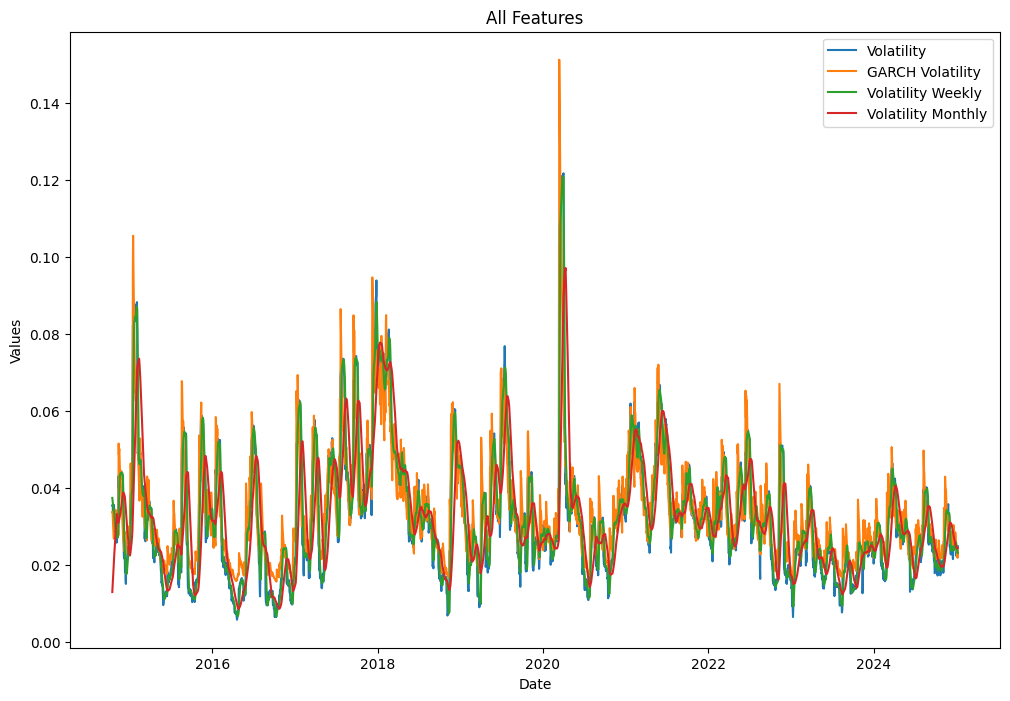

MSE between Volatility and GARCH Volatility: 4.3626126328517856e-05
MAPE between Volatility and GARCH Volatility: 0.19344284043934798


In [13]:
# plot all features on the same graph
plt.figure(figsize=(12, 8))

plt.plot(features["Date"], features["Volatility"], label="Volatility")
plt.plot(features["Date"], features["GARCH Volatility"], label="GARCH Volatility")
plt.plot(features["Date"], features["Volatility Weekly"], label="Volatility Weekly")
plt.plot(features["Date"], features["Volatility Monthly"], label="Volatility Monthly")

plt.title("All Features")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.show()

#mse between the volatility and the GARCH volatility
mse = ((features["Volatility"] - features["GARCH Volatility"]) ** 2).mean()
print(f"MSE between Volatility and GARCH Volatility: {mse}")

# mape between the volatility and the GARCH volatility
mape = (abs(features["Volatility"] - features["GARCH Volatility"]) / features["Volatility"]).mean()
print(f"MAPE between Volatility and GARCH Volatility: {mape}")

### Entrainement du modèle de deep learning

In [9]:
from crypto_volatility_lab.modeling import LSTMPipeline, GRUPipeline, LSTMGRUPipeline

data = features[["Volatility", "GARCH Volatility", "Volatility Weekly", "Volatility Monthly"]].values
pipeline = GRUPipeline(forecast_horizon=5, epochs=80, batch_size=32, validation_split=0.1)

model = pipeline.fit(data, features["Volatility"].values.astype(np.float64))

Epoch 1/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 3.9704e-04 - val_loss: 1.7956e-05
Epoch 2/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.0778e-05 - val_loss: 3.0450e-05
Epoch 3/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.5344e-05 - val_loss: 1.8098e-05
Epoch 4/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.4526e-05 - val_loss: 6.9736e-05
Epoch 5/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 8.1265e-05 - val_loss: 1.0672e-05
Epoch 6/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.3585e-05 - val_loss: 1.1435e-05
Epoch 7/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.1545e-05 - val_loss: 1.2485e-05
Epoch 8/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.3922e-05 - val_loss: 6.6954e-05
Epoch 9/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.4779e-05 - val_loss: 2.1948e-05
Epoch 10/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.1439e-05 - val_loss: 2.8675e-05
Epoch 11/80
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/

In [10]:
pipeline.evaluate_metrics(data, features["Volatility"].values.astype(np.float64))

Train Loss (MSE from history): 6.525712524307892e-05
Validation Loss (MSE from history): 1.4551341337210033e-05
Mean Squared Error (MSE): 0.0000
Mean Absolute Error (MAE): 0.0044
Mean Absolute Percentage Error (MAPE): 16.7376%


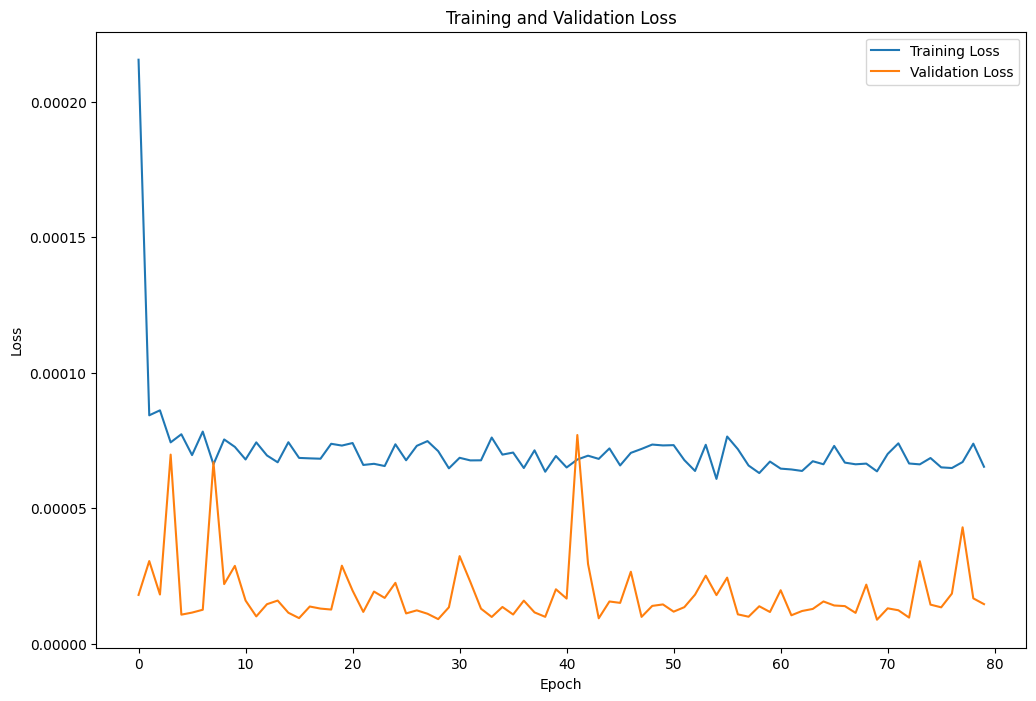

In [11]:
history = pipeline.get_history()

# plot the training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [12]:
y_pred= pipeline.predict(data)
print(y_pred.shape)

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(3708, 5)


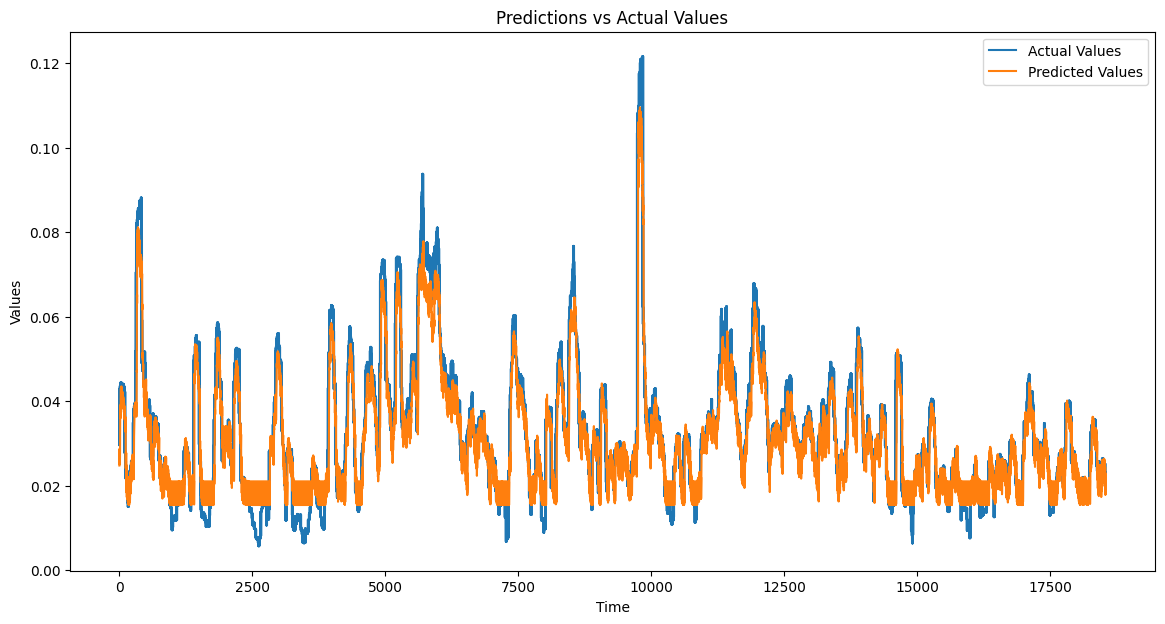

In [13]:
pipeline.plot_predictions(data, features["Volatility"].values.astype(np.float64))

### add test evaluation